## เขียน Python code สำหรับ Density functional theory ใน 1 มิติ อย่างง่าย

#### import library ที่จำเป็น

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### สมการโคห์น-ชาม (Khon-Sham equation)
$$
\left ( -\frac{1}{2}\frac{\mathrm{d}^2 }{\mathrm{d} x}+V_{eff} \right )\psi=E\psi

$$
โดยที่
$$
V_{eff}=V_H+V_{ext}+V_{xc}
$$

$V_H$ คือ ศักย์ฮาร์ทรี (Hartree potential): ศักย์ไฟฟ้าเนื่องจากอัตกริยาระหว่างอิเล็กตรอน, 
$V_{ext}$ คือ ศักย์ภายนอก (external potential): ศักย์ไฟฟ้าเนื่องมาจากอิเล็กตรอนและนิวเคลียส์, 
$V_{xc}$ คือศักย์ความสัมพันธ์แลกเปลี่ยน (exchange-correlation potential)

In [58]:
N = 500
x = np.linspace(-5,5,N)
dx = x[1]-x[0]

#### Differential operator

นิยามตัวดำเนินการอนุพันธ์อันดับหนึ่งและสอง (1st & 2nd differential operator) โดยใช้ระเบียบวิธีผลต่างจำกัด (Finite Difference Method)

สำหรับ ตัวดำเนินการอนุพันธ์อันดับหนึ่ง
$$
\frac{\mathrm{d} y}{\mathrm{d} x}|_{x_i}\approx \frac{y_{i+1}-y_i}{\Delta x}
$$
เขียนในรูป dot product ของเมทริกซ์ $[D]\cdot[y]$ ดังนั้น $[D]$ จะนิยามเป็น
$$
D_{i,j}=\frac{\delta_{i+1,j}-\delta_{i,j}}{\Delta x}
$$

In [59]:
D = (np.diagflat(np.ones(N-1),1) - np.eye(N))/dx

สำหรับ ตัวดำเนินการอนุพันธ์อันดับสอง
$$
\frac{\mathrm{d}^2 y}{\mathrm{d} x^2}|_{x_i}\approx \frac{y_{i+1}-2y_i+y_{i-1}}{(\Delta x)^2}
$$
เขียนในรูป dot product ของเมทริกซ์ $[D^2]\cdot[y]$ ดังนั้น $[D^2]$ จะนิยามเป็น
$$
D^2_{i,j}=\frac{\delta_{i+1,j}-2\delta_{i,j}+\delta_{i-1,j}}{(\Delta x)^2}
$$

In [60]:
D2 = (np.diagflat(np.ones(N-1),1) - 2*np.eye(N) +np.diagflat(np.ones(N-1),-1))/dx**2

ลองทดสอบตัวดำเนินการ ด้วย $y(x)=x^3+2x$

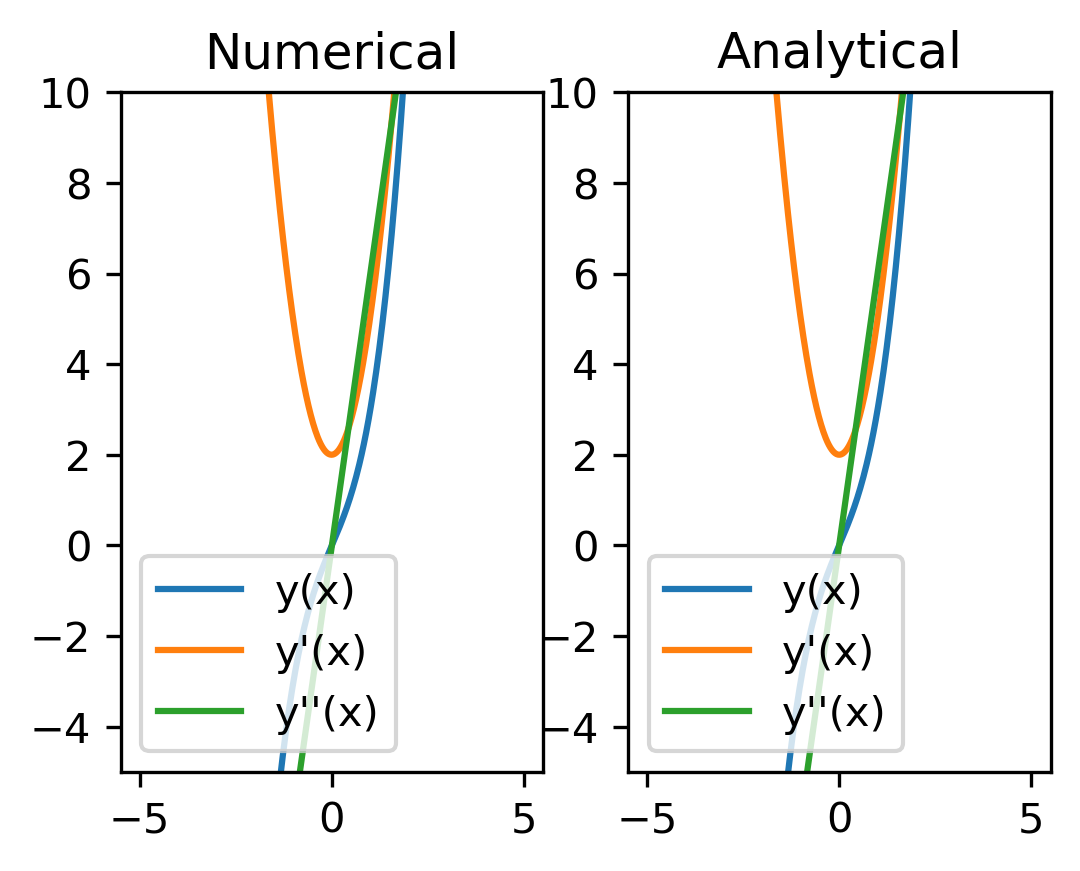

In [148]:
y = x**3+2*x
plt.figure(figsize=(4,3), dpi=300)
plt.subplot(121)
plt.title('Numerical')
plt.ylim(-5,10)
plt.plot(x, y,label='y(x)')
plt.plot(x[:-1], D.dot(y)[:-1],label='y\'(x)')
plt.plot(x[1:-1], D2.dot(y)[1:-1],label='y\'\'(x)')
plt.legend()
plt.subplot(122)
plt.title('Analytical')
plt.ylim(-5,10)
plt.plot(x, y,label='y(x)')
plt.plot(x,3*x**2+2,label='y\'(x)')
plt.plot(x, 6*x,label='y\'\'(x)')
plt.legend()

เห็นว่าตัวกำเนินการอนุพันธ์เชิงตัวเลขสามารถให้ค่าได้ใกล้เคียง Analytical 

#### ทดสอบกับระบบอย่างง่าย (1 อิเล็กตรอน)

Harmonic oscillator
$$
\hat{H}=-\frac{1}{2}\frac{\mathrm{d}^2 }{\mathrm{d} x}+x^2
$$

In [121]:
X2 = np.diagflat(x*x)
eig, psi_har = np.linalg.eigh(-D2/2+X2)

plot เปรียบเทียบผล

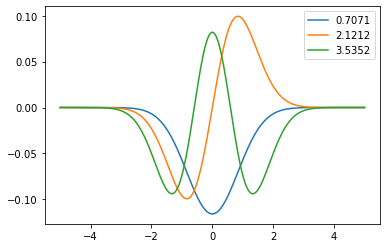

In [122]:
for i in range(3):
    plt.plot(x,psi_har[:,i], label=f"{eig[i]:.4f}")
    plt.legend(loc=1)

#### Density
เมื่อระบบของเรามีจำนวนของอเล็กตรอนที่มากขึ้น จึงต้องมีการคำนวนอิเล็กตรอนแต่ละตัว การมาของ density functional มาเพื่อช่วยลดความยากในการคำนวน

อย่างแรกเนื่องด้วย normalization condiation เราจำเป็นต้องทำการ normalize ฟังก์ชันคลื่นด้วย
$$
\int |\psi|^2dx=1
$$

In [88]:
def norm_psi(psi,x):
    temp = 0.0
    N = x.size-1
    dx = x[1]-x[0]
    for i in range(1,N):
        temp += psi[i]**2.0
    ans = dx/2.0*(psi[0]**2.0+psi[N]**2.0+2.0*temp)
    return psi/np.sqrt(ans)

และสามารถหา density ได้จาก 
$$
n(x)=\sum_n f_n|\psi(x)|^2
$$
โดยที่ $f_n$ คือ จำนวนของอิเล็กตรอนที่ occupied ในแต่ละ state n โดยที่แต่ละ state สามารถมีได้ 2 อิเล็กตรอน (ซึ่งใน density functional theory เราคำนวนเพียง ground state)

In [89]:
def get_nx(num_e, psi, x):
    normed_psi = norm_psi(psi,x)

    fn = [2 for _ in range(num_e//2)]
    if num_e % 2 != 0:
        fn.append(1)

    res=np.zeros_like(normed_psi[:,0])
    for ne, psi  in zip(fn,normed_psi.T):
        res += ne*(psi**2)
    return res

กำหนดจำนวนอิเล็กตรอน

In [100]:
num_electron = 17

plot density ของอิเล็กตรอน

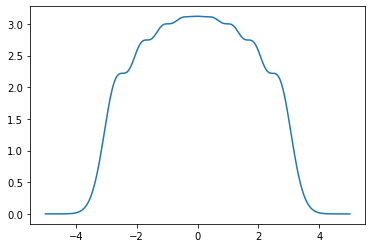

In [123]:
plt.plot(x, get_nx(num_electron, psi_har, x))

ซึ่งนี้ยังเป็น density ที่ไม่ถูกต้อง เนื่องจาก density นี้ได้มาจากฟังก์ชันคลื่นของ 1 อิเล็กตรอน (เสมือนคำนวณแบบอิเล็กตรอนไม่มีอันตรกิริรยาต่อกัน no-interaction) เราจึงต้องเพิ่มเทอมของศักย์อันเนื่องมาจากอิเล็กตรอนหลายตัวเข้าไปใน Hamiltonian operator

#### exchange potential
เพื่อความง่ายต่อการเขียน code เราจะยีงไม่สนใจ correlation potential และสนใจ exchange potential แบบ Local density Approximation (LDA) หรือ การประมาณความหนาแน่นเฉพาะที่ ซึ่งอาศัยสมมติฐานว่าอิเล็กตรอนมีการกระจายตัวอย่างสม่ำเสมอ

$$
E^{LDA}_x[n] = -\frac{3}{4}\left ( \frac{3}{\pi} \right )^{1/3}\int n^{4/3}dn
$$
$$
V^{LDA}_x[n]=\frac{\partial E^{LDA}_x}{\partial n}=-\left ( \frac{3}{\pi} \right )^{1/3}n^{1/3}
$$

In [102]:
def get_lda(nx):
    v = -(3/np.pi)**(1/3)*nx**(1/3)
    return v

#### Hartree potential

$$
E_{H}=\frac{1}{2}\int \int \frac{n(x)n(x')}{\sqrt{(x-x')^2+\varepsilon }}dxdx'
$$
$$
\begin{align*} 
V_{H}&=\int \frac{n(x')}{\sqrt{(x-x')^2+\varepsilon }}dx'\\
&\approx \sum_j \frac{n_j\Delta x}{\sqrt{(x_i-x_j)^2+\varepsilon }}
\end{align*}
$$

In [103]:
def get_hatree(nx,x, eps=1e-1):
    dx=x[1]-x[0]
    v = np.sum(nx[None,:]*dx/np.sqrt((x[None,:]-x[:,None])**2+eps),axis=-1)
    return v 

จะเห็นได้ว่าเราต้องทราบ $n(x)$ ก่อนที่จะหา ฟังก์ชันคลื่นได้ กลับกัน $n(x)$ ต้องคำนวณมาจาก ฟังก์ชันคลื่น เราต้องใช้ self-consistent method

#### self-consistent method


1. กำหนด density เริ่มต้น
2. คำนวณศักย์ Exchange และ Hatree
3. กำหนด Hamiltonian
4. แก้สมการไอเกน $H\psi=E\psi$
5. ตรวจสอบการลู่เข้าของพลังงาน
6. ถ้าพลังงานยังไม่ลู่เข้า คำนวณ density ใหม่ จากฟังก์ชันคลื่น แล้วกลับไปที่ข้อ 2.

In [104]:
def print_log(i,log):
    print(f"step: {i:<5} energy: {log['energy'][-1]:<10.4f} energy_diff: {log['energy_diff'][-1]:.10f}")

In [109]:
max_iter=1000
energy_tolerance=1e-6
log={"energy":[float("inf")], "energy_diff":[float("inf")]}

In [110]:
nx=np.zeros(N)
for i in range(max_iter):
    ex_potential=get_lda(nx)
    ha_potential=get_hatree(nx,x)
    
    H=-D2/2+np.diagflat(ex_potential+ha_potential+x**2)
    
    energy, psi= np.linalg.eigh(H)
    
    log["energy"].append(energy[0])
    energy_diff=energy[0]-log["energy"][-2]
    log["energy_diff"].append(energy_diff)
    print_log(i,log)
    
    if abs(energy_diff) < energy_tolerance:
        print("converged!")
        break

    nx=get_nx(num_electron,psi,x)
else:
    print("not converged")

step: 0     energy: 0.7071     energy_diff: -inf
step: 1     energy: 16.3512    energy_diff: 15.6441053413
step: 2     energy: 13.8054    energy_diff: -2.5457660245
step: 3     energy: 15.2893    energy_diff: 1.4838408017
step: 4     energy: 14.4126    energy_diff: -0.8766469149
step: 5     energy: 14.9387    energy_diff: 0.5261192172
step: 6     energy: 14.6225    energy_diff: -0.3162822809
step: 7     energy: 14.8137    energy_diff: 0.1912451190
step: 8     energy: 14.6979    energy_diff: -0.1157557553
step: 9     energy: 14.7681    energy_diff: 0.0702042923
step: 10    energy: 14.7256    energy_diff: -0.0425943634
step: 11    energy: 14.7514    energy_diff: 0.0258605063
step: 12    energy: 14.7357    energy_diff: -0.0157027363
step: 13    energy: 14.7452    energy_diff: 0.0095370504
step: 14    energy: 14.7395    energy_diff: -0.0057925261
step: 15    energy: 14.7430    energy_diff: 0.0035184860
step: 16    energy: 14.7408    energy_diff: -0.0021372115
step: 17    energy: 14.7421   

plot ฟังก์ชันคลื่นของระบบ

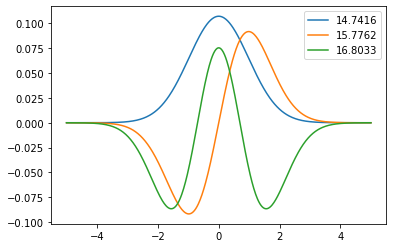

In [115]:
for i in range(3):
    plt.plot(x,psi[:,i], label=f"{energy[i]:.4f}")
    plt.legend(loc=1)

plot density 

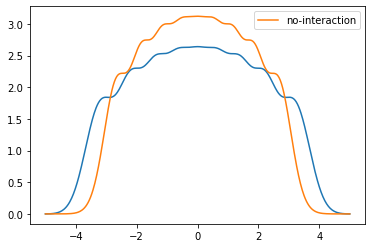

In [150]:
plt.plot(x,nx)
plt.plot(x, get_nx(num_electron, psi_har, x), label='no-interaction')
plt.legend()